#Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from PIL import Image

#Image Dataset

In [ ]:
from google.colab import files

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = '1-1c6DKZ6L972eY1F1990ubvvZgndKmO2'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('artists.csv')

In [ ]:
artists = pd.read_csv('artists.csv')

In [ ]:
artists.head(15)

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194
5,5,Salvador Dali,1904 - 1989,Surrealism,Spanish,Salvador Domingo Felipe Jacinto Dalí i Domènec...,http://en.wikipedia.org/wiki/Salvador_Dalí,139
6,6,Edouard Manet,1832 - 1883,"Realism,Impressionism",French,Édouard Manet (US: ; UK: ; French: [edwaʁ manɛ...,http://en.wikipedia.org/wiki/Édouard_Manet,90
7,7,Andrei Rublev,1360 - 1430,Byzantine Art,Russian,"Andrei Rublev (Russian: Андре́й Рублёв, IPA: [...",http://en.wikipedia.org/wiki/Andrei_Rublev,99
8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
9,9,Gustav Klimt,1862 - 1918,"Symbolism,Art Nouveau",Austrian,"Gustav Klimt (July 14, 1862 – February 6, 1918...",http://en.wikipedia.org/wiki/Gustav_Klimt,117


In [ ]:
directory = '/content/drive/MyDrive/Colab Notebooks/images/images'

#Imports y constantes

In [ ]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

random.seed(7)
torch.manual_seed(7)

In [ ]:
#number of workers for dataloader
workers = 2

#batch size during training
batch_size = 100

#size of training images
image_size = 32

#number of channels in the training images
nc = 3

#size of z latent vector (i.e. size of generator input)
nz = 100

#size of feature maps in generator
ngf = 64

#size of feature maps in discriminator
ndf = 64

#learning rate for optimizers
lr = 0.0002

#beta1 hyperparam for Adam optimizers
beta1 = 0.5

#number of GPUs available
ngpu = 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Dataset

In [ ]:
dataset = dset.ImageFolder(root=directory,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

#Dataloader

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

#Algunas imágenes

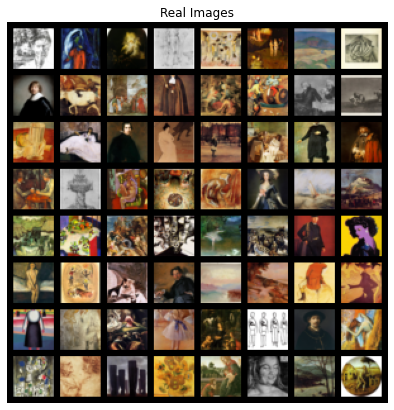

In [ ]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

#Generator

In [ ]:
#custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.Conv2d(ngf, nc, 1, 1, 0, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
#creamos el generador
netG = Generator(ngpu).to(device)

#gpu
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

#aplicamos inicialización de pesos
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (13): Tanh()
  )
)


#Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # state size. (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
#creamos el discriminador
netD = Discriminator(ngpu).to(device)

#gpu
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

#aplicamos inicialización de pesos
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [ ]:
#initialize BCELoss function
criterion = nn.BCELoss()

#create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

#establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

#setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

#Cargo generador y discriminador entrenados con 250 epochs

In [ ]:
import pickle

Generador:

In [ ]:
with open('generator (6).pkl', 'rb') as pickle_in:
     netG = pickle.load(pickle_in)

Discriminador:

In [ ]:
with open('discriminator (6).pkl', 'rb') as pickle_in:
     netD = pickle.load(pickle_in)

In [ ]:
#@title Acá podés elegir tu semilla { run: "auto" }
semilla = 23 #@param {type:"slider", min:0, max:100, step:1}

random.seed(semilla)
torch.manual_seed(semilla)

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [ ]:
import pickle

In [ ]:
filename = 'generator.pkl'
pickle.dump(netG, open(filename, 'wb'))

In [ ]:
filename = 'discriminator.pkl'
pickle.dump(netD, open(filename, 'wb'))

#Training Loop

Defino cantidad de epochs:

In [ ]:
num_epochs = 10

In [ ]:
#lists to keep track of progress
img_list = []  
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):

    #for each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        #TRAIN WITH ALL REAL BATCH
        netD.zero_grad()

        #format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        #forward pass real batch through D
        output = netD(real_cpu).view(-1)

        #calculate loss on all-real batch
        errD_real = criterion(output, label)

        #calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        #TRAIN WITH ALL FAKE BATCH
        #generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        #generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)

        #classify all fake batch with D
        output = netD(fake.detach()).view(-1)

        #calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)

        #calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        #add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        #update D
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)  #fake labels are real for generator cost
        #since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        #calculate G's loss based on this output
        errG = criterion(output, label)
        #calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        #update G
        optimizerG.step()

        #uutput training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        #save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        #check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/88]	Loss_D: 1.0970	Loss_G: 1.0210	D(x): 0.5824	D(G(z)): 0.3885 / 0.3885
[0/10][50/88]	Loss_D: 1.1082	Loss_G: 1.0048	D(x): 0.5958	D(G(z)): 0.3978 / 0.3978
[1/10][0/88]	Loss_D: 0.9429	Loss_G: 1.1518	D(x): 0.6331	D(G(z)): 0.3461 / 0.3461
[1/10][50/88]	Loss_D: 1.2243	Loss_G: 1.3620	D(x): 0.4592	D(G(z)): 0.2917 / 0.2917
[2/10][0/88]	Loss_D: 1.1736	Loss_G: 1.0723	D(x): 0.5461	D(G(z)): 0.3748 / 0.3748
[2/10][50/88]	Loss_D: 0.9337	Loss_G: 0.9877	D(x): 0.6998	D(G(z)): 0.4060 / 0.4060
[3/10][0/88]	Loss_D: 1.0046	Loss_G: 1.1508	D(x): 0.6063	D(G(z)): 0.3521 / 0.3521
[3/10][50/88]	Loss_D: 1.0167	Loss_G: 1.2986	D(x): 0.5453	D(G(z)): 0.2993 / 0.2993
[4/10][0/88]	Loss_D: 1.0363	Loss_G: 1.3246	D(x): 0.5579	D(G(z)): 0.2987 / 0.2987
[4/10][50/88]	Loss_D: 1.4182	Loss_G: 0.9339	D(x): 0.4843	D(G(z)): 0.4257 / 0.4257
[5/10][0/88]	Loss_D: 0.8073	Loss_G: 1.2578	D(x): 0.6926	D(G(z)): 0.3159 / 0.3159
[5/10][50/88]	Loss_D: 1.0921	Loss_G: 0.9842	D(x): 0.6226	D(G(z)): 0.4116 / 0.4

Mostramos algunas imágenes:

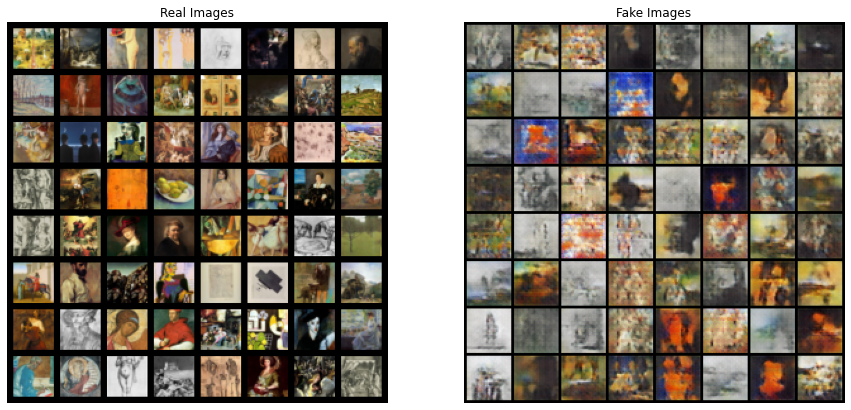

In [ ]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15, 15))

#real images
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

#fake images
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))

plt.show()